# DLT Quick Start

**DLT** stands for `Damped Local Trend` model, which is an important model type in orbit package. In the model equation, there is a local trend term and a global trend term.

In this notebook we will show how to use Orbit DLT models with the US unemployment claims data and different gloabl trend options.

In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
from datetime import timedelta

import pandas as pd
import numpy as np

import orbit
from orbit.models import DLT
from orbit.diagnostics.plot import plot_predicted_data, plot_predicted_components
from orbit.utils.dataset import load_iclaims

In [2]:
orbit.__version__

'1.1.0dev'

## Data

*iclaims_example* is a dataset containing the weekly initial claims for US unemployment benefits against a few related google trend queries (unemploy, filling and job) from Jan 2010 - June 2018.

This aim is to mimick the dataset from the paper [Predicting the Present with Bayesian Structural Time Series](https://people.ischool.berkeley.edu/~hal/Papers/2013/pred-present-with-bsts.pdf) by SCOTT and VARIAN (2014).

Number of claims are obtained from [Federal Reserve Bank of St. Louis](https://fred.stlouisfed.org/series/ICNSA) while google queries are obtained through [Google Trends API](https://trends.google.com/trends/?geo=US).
Note that dataset is transformed by natural log before fitting in order to have a multiplicative model.

In [3]:
# load data
df = load_iclaims()

df.dtypes

week              datetime64[ns]
claims                   float64
trend.unemploy           float64
trend.filling            float64
trend.job                float64
sp500                    float64
vix                      float64
dtype: object

In [4]:
df.head()

,week,claims,trend.unemploy,trend.filling,trend.job,sp500,vix
0,2010-01-03,13.386595,0.219882,-0.318452,0.117500,-0.417633,0.122654
1,2010-01-10,13.624218,0.219882,-0.194838,0.168794,-0.425480,0.110445
2,2010-01-17,13.398741,0.236143,-0.292477,0.117500,-0.465229,0.532339
3,2010-01-24,13.137549,0.203353,-0.194838,0.106918,-0.481751,0.428645
4,2010-01-31,13.196760,0.134360,-0.242466,0.074483,-0.488929,0.487404


In [5]:
DATE_COL = 'week'
RESPONSE_COL = 'claims'

### Train / Test Split

In [6]:
test_size = 52

train_df = df[:-test_size]
test_df = df[-test_size:]

In [7]:
train_df.head()

,week,claims,trend.unemploy,trend.filling,trend.job,sp500,vix
0,2010-01-03,13.386595,0.219882,-0.318452,0.117500,-0.417633,0.122654
1,2010-01-10,13.624218,0.219882,-0.194838,0.168794,-0.425480,0.110445
2,2010-01-17,13.398741,0.236143,-0.292477,0.117500,-0.465229,0.532339
3,2010-01-24,13.137549,0.203353,-0.194838,0.106918,-0.481751,0.428645
4,2010-01-31,13.196760,0.134360,-0.242466,0.074483,-0.488929,0.487404


## DLT Model

**DLT** stands for Damped Local Trend model,

$$ y_{t}  = \hat{y}_t + \epsilon $$
$$\hat{y}_t=\mu_t + s_t + r_t $$
$$\mu_t=D(t) + l_{t-1} +  \theta{b_{t-1}}$$

with the update process as such 

$$g_t = D(t)$$
$$l_t = \rho_l(y_t - g_{t} - s_t - r_t) + (1-\rho_l)l_{t-1}$$
$$b_t=  \rho_b(l_t - l_{t-1}) + (1-\rho_b)\theta{b_{t-1}}$$
$$s_{t+m} =  \rho_s(y_t - l_t - r_t) + (1-\rho_s)s_t$$
$$r_t =  \Sigma_{j}\beta_j x_{jt}$$

There are a few choices of $D(t)$ as a global trend, such as linear, log-linear and logistic. Another feature of DLT is the regression component $r_t$. This serves the purpose of nowcasting or forecasting when exogenous regressors are known such as events and holidays.  Without losing generality, assume

$$\beta_j ~\sim \mathtt{Normal}(\mu_j, \sigma_j)$$

where $\mu_j = 0$  and $\sigma_j = 1$ by default as a non-informative prior. There are more choices of priors for the regression component in the package.

In orbit, we have three different wrappers for DLT models, `DLTMAP`, `DLTAggregated` and  `DLTFull`

### DLTMAP

DLT model for MAP (Maximum a Posteriori) prediction

In [8]:
dlt = DLT(response_col=RESPONSE_COL,
          date_col=DATE_COL,
          estimator='stan-map',
          seasonality=52,
          seed=8888)

In [9]:
dlt.fit(df=train_df)

Initial log joint probability = 433.003
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      19       772.065      0.169519       43.2983      0.4173           1       22   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      39       785.058     0.0624721       21.2949           1           1       43   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      59       792.427     0.0543364       18.7019           1           1       64   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      79       793.194     0.0206283       4.67972      0.5295     0.05295       88   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       793.512     0.0132951       3.49675           1           1      109   
    Iter      log prob        ||dx||      ||grad||       alpha   

  794.957     0.0457898       15.9754           1           1      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     139       795.336     0.0178317       4.86531           1           1      155   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     159       796.322       0.50026       12.9246           1           1      175   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     179       796.628       0.14306       3.97902           1           1      196   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        796.64     0.0540112       1.44307           1           1      216   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     219       796.644     0.0163202      0.403569           1           1      236   
    Iter      log prob        |

In [10]:
predicted_df = dlt.predict(df=test_df, decompose=True)
predicted_df.head()

,week,prediction,trend,seasonality,regression
0,2017-07-02,12.425115,12.362171,0.062944,0.0
1,2017-07-09,12.545215,12.359985,0.185230,0.0
2,2017-07-16,12.382082,12.357799,0.024283,0.0
3,2017-07-23,12.235720,12.355613,-0.119893,0.0
4,2017-07-30,12.189179,12.353427,-0.164248,0.0


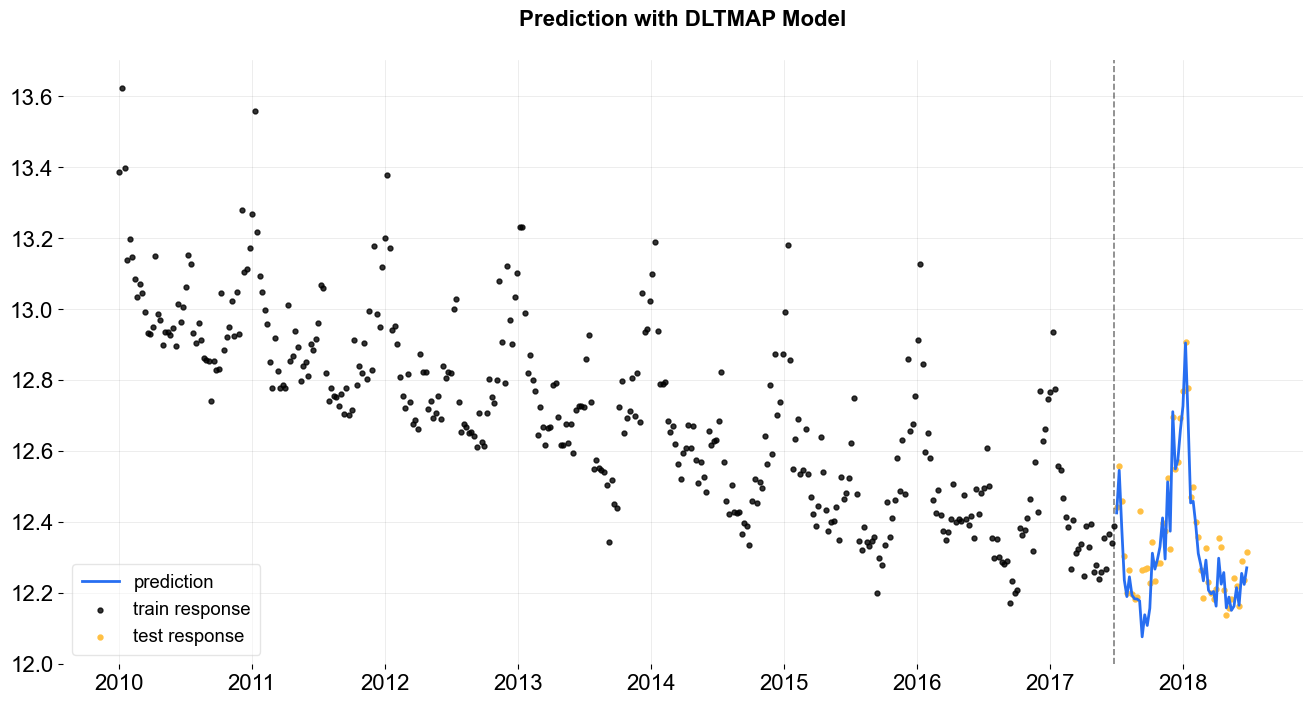

In [11]:
_ = plot_predicted_data(training_actual_df=train_df,
                        predicted_df=predicted_df,
                        date_col=DATE_COL,
                        actual_col=RESPONSE_COL,
                        test_actual_df=test_df,
                        title='Prediction with DLTMAP Model')

### DLTFull

LGT model for full prediction. In full prediction, the prediction occurs as a function of each parameter posterior sample, and the prediction results are aggregated after prediction. Prediction will always return the median (aka 50th percentile) along with any additional percentiles that are specified.

In [12]:
dlt = DLT(response_col=RESPONSE_COL,
          date_col=DATE_COL,
          estimator='stan-mcmc',
          seasonality=52,
          seed=8888)

In [13]:
dlt.fit(df=train_df, point_method=None)


Gradient evaluation took 0.000957 seconds
1000 transitions using 10 leapfrog steps per transition would take 9.57 seconds.
Adjust your expectations accordingly!


Gradient evaluation took 0.001314 seconds
1000 transitions using 10 leapfrog steps per transition would take 13.14 seconds.

Adjust your expectations accordingly!



Gradient evaluation took 0.001021 seconds
1000 transitions using 10 leapfrog steps per transition would take 10.21 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.00097 seconds
1000 transitions using 10 leapfrog steps per transition would take 9.7 seconds.
Adjust your expectations accordingly!


Iteration:   1 / 250 [  0%]  (Warmup)
Iteration:   1 / 250 [  0%]  (Warmup)
Iteration:   1 / 250 [  0%]  (Warmup)
Iteration:   1 / 250 [  0%]  (Warmup)
Iteration:  25 / 250 [ 10%]  (Warmup)
Iteration:  25 / 250 [ 10%]  (Warmup)
Iteration:  25 / 250 [ 10%]  (Warmup)
Iteration:  25 / 250 [ 10%]  (Warmup)
Iteration:  50 / 250 [ 20%]  (Warmup)
It

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [14]:
predicted_df = dlt.predict(df=test_df, decompose=True)

In [15]:
predicted_df.tail()

,week,prediction_5,prediction,prediction_95,trend_5,trend,trend_95,seasonality_5,seasonality,seasonality_95,regression_5,regression,regression_95
47,2018-05-27,12.110832,12.236411,12.365385,12.128032,12.263236,12.397356,-0.062333,-0.026229,0.004478,0.0,0.0,0.0
48,2018-06-03,12.059123,12.178334,12.289549,12.122517,12.264409,12.391919,-0.124890,-0.089371,-0.059832,0.0,0.0,0.0
49,2018-06-10,12.091117,12.275301,12.384388,12.075026,12.266047,12.396658,-0.027669,0.005910,0.036730,0.0,0.0,0.0
50,2018-06-17,12.117888,12.241044,12.329424,12.130024,12.265470,12.360317,-0.056947,-0.023349,0.006623,0.0,0.0,0.0
51,2018-06-24,12.170938,12.299122,12.382156,12.129455,12.267339,12.371585,-0.007233,0.026003,0.055168,0.0,0.0,0.0


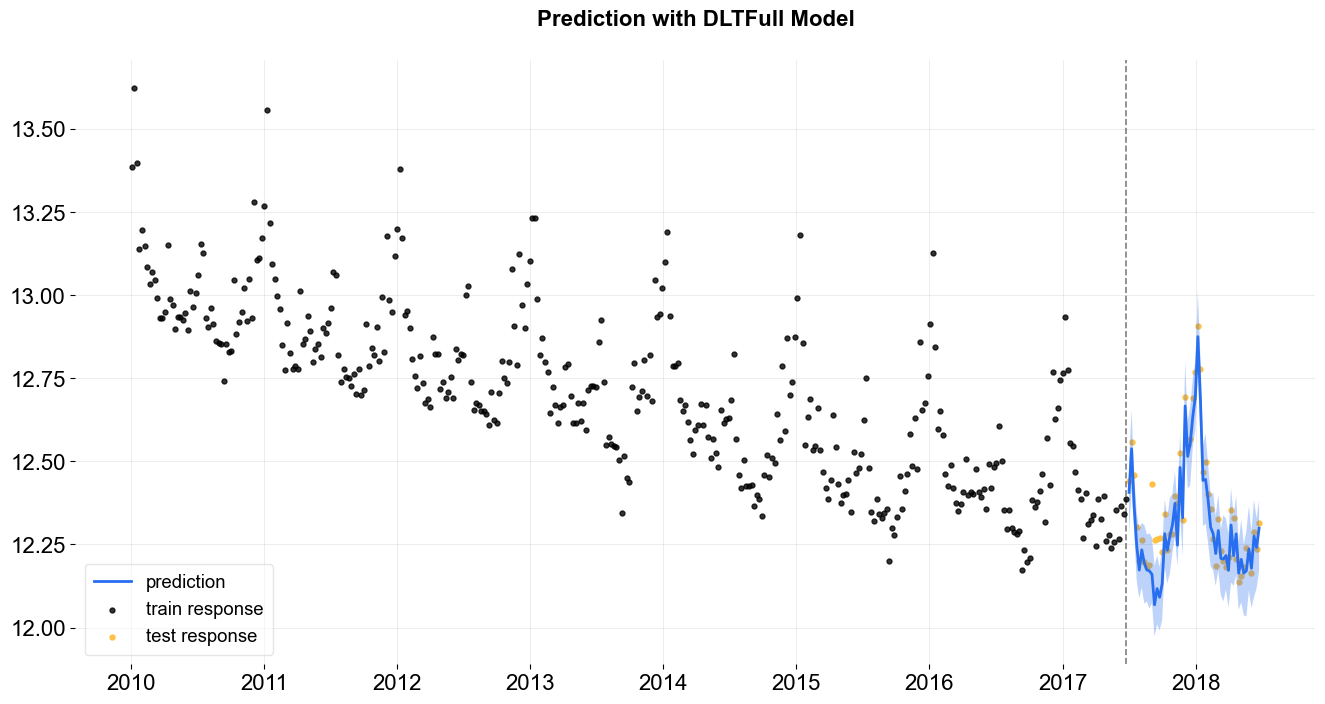

In [16]:
_ = plot_predicted_data(training_actual_df=train_df,
                        predicted_df=predicted_df,
                        date_col=DATE_COL,
                        actual_col=RESPONSE_COL,
                        test_actual_df=test_df,
                        title='Prediction with DLTFull Model')

### DLTAggregated

DLT model for aggregated posterior prediction. In aggregated prediction, the parameter posterior samples are reduced using `aggregate_method ({ 'mean', 'median' })` before performing a single prediction.

In [17]:
dlt = DLT(response_col=RESPONSE_COL,
           date_col=DATE_COL,
           estimator='stan-mcmc',
           seasonality=52,
           seed=8888)

In [18]:
dlt.fit(df=train_df, point_method='mean')



Gradient evaluation took 0.000896 seconds
Gradient evaluation took 0.000777 seconds
1000 transitions using 10 leapfrog steps per transition would take 7.77 seconds.
Adjust your expectations accordingly!


1000 transitions using 10 leapfrog steps per transition would take 8.96 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000718 seconds
1000 transitions using 10 leapfrog steps per transition would take 7.18 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000739 seconds
1000 transitions using 10 leapfrog steps per transition would take 7.39 seconds.
Adjust your expectations accordingly!


Iteration:   1 / 250 [  0%]  (Warmup)
Iteration:   1 / 250 [  0%]  (Warmup)
Iteration:   1 / 250 [  0%]  (Warmup)
Iteration:   1 / 250 [  0%]  (Warmup)
Iteration:  25 / 250 [ 10%]  (Warmup)
Iteration:  25 / 250 [ 10%]  (Warmup)
Iteration:  25 / 250 [ 10%]  (Warmup)
Iteration:  25 / 250 [ 10%]  (Warmup)
Iteration:  50 / 250 [ 20%]  (Warmup)
It

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Iteration: 250 / 250 [100%]  (Sampling)

 Elapsed Time: 3.62058 seconds (Warm-up)
               0.172171 seconds (Sampling)
               3.79276 seconds (Total)



In [19]:
predicted_df = dlt.predict(df=test_df, decompose=True)

In [20]:
predicted_df.tail()

,week,prediction,trend,seasonality,regression
47,2018-05-27,12.235614,12.264152,-0.028538,0.0
48,2018-06-03,12.173141,12.262197,-0.089056,0.0
49,2018-06-10,12.267156,12.260243,0.006913,0.0
50,2018-06-17,12.235667,12.258288,-0.022622,0.0
51,2018-06-24,12.282595,12.256334,0.026261,0.0


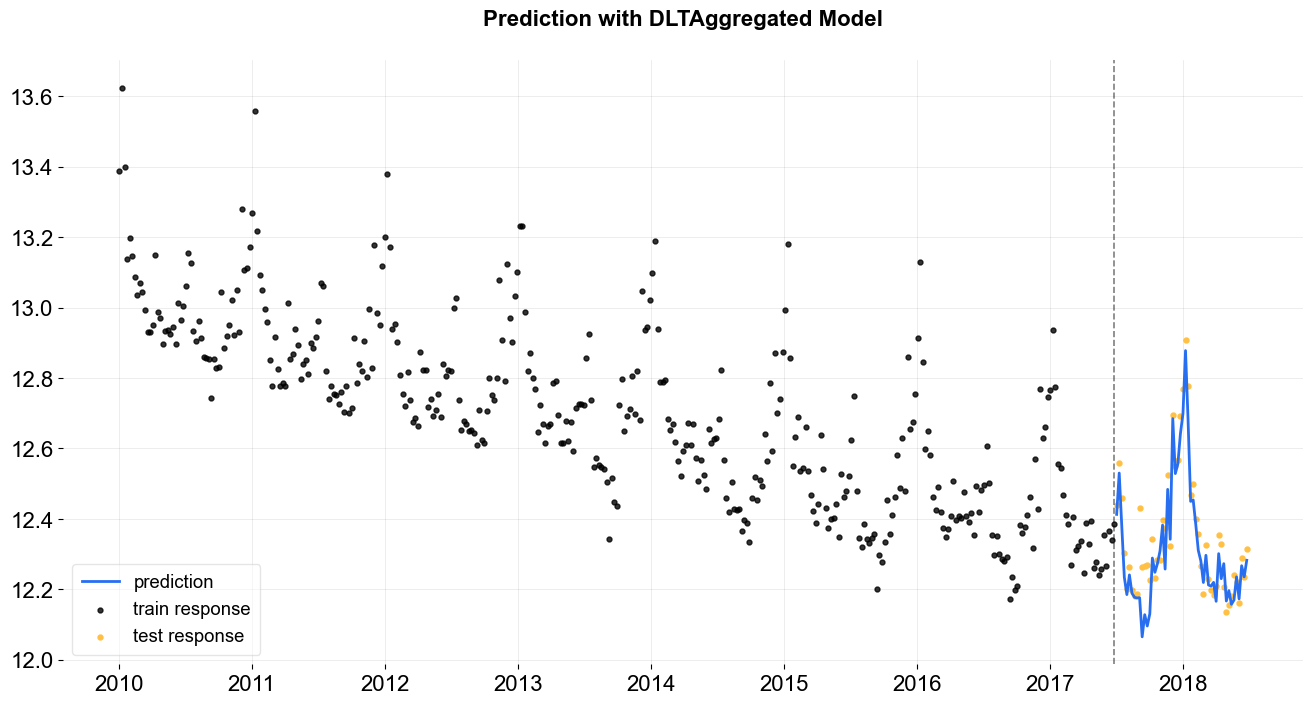

In [21]:
_ = plot_predicted_data(training_actual_df=train_df,
                        predicted_df=predicted_df,
                        date_col=DATE_COL,
                        actual_col=RESPONSE_COL,
                        test_actual_df=test_df,
                        title='Prediction with DLTAggregated Model')

## DLT Model with Global Trend

The main differences between `DLT` and `LGT` are mainly:

- It introduces a damped factor on local trend
- It models global trend as a determinstic projection

There are four options in modeling the `global trend` with the `global_trend_option` arguemnt:

1. `linear`
2. `loglinear`
3. `logistic`
4. `flat`

The behavior of these three options will depend on the condition of `is_multiplicative` as well.  Below, we only show cases with condition when `is_multiplicative` as `True` since it is the default.

### Data

Instead of splitting the data into train and test. We will use the full data set to train and simulate the multiplicative prediction data in the following 4 years.

In [22]:
num_periods = 52 * 4

freq = 7

last_dt = (df[DATE_COL].dt.to_pydatetime())[-1]

dts = [last_dt + timedelta(days=x * freq) for x in range(1, num_periods + 1)]

future_df = pd.DataFrame(dts, columns=[DATE_COL])

### Linear Trend

In multiplicative model, the linear trend as default will be transformed as exponential growth/decay.

In [23]:
dlt = DLT(response_col=RESPONSE_COL,
          date_col=DATE_COL,
          estimator='stan-map',
          seasonality=52,
          seed=8888)

In [24]:
dlt.fit(df)

Initial log joint probability = 496.078


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      19       873.235      0.221233       62.9304      0.4999           1       23   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      39       891.156      0.132971       33.1847           1           1       47   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      59       899.935     0.0425986       13.1857           1           1       69   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      79       900.928    0.00137651       3.88758      0.5154      0.5154       93   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       901.534     0.0103503       3.08814      0.9142      0.9142      113   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     119     

In [25]:
predicted_df = dlt.predict(df=future_df, decompose=True)

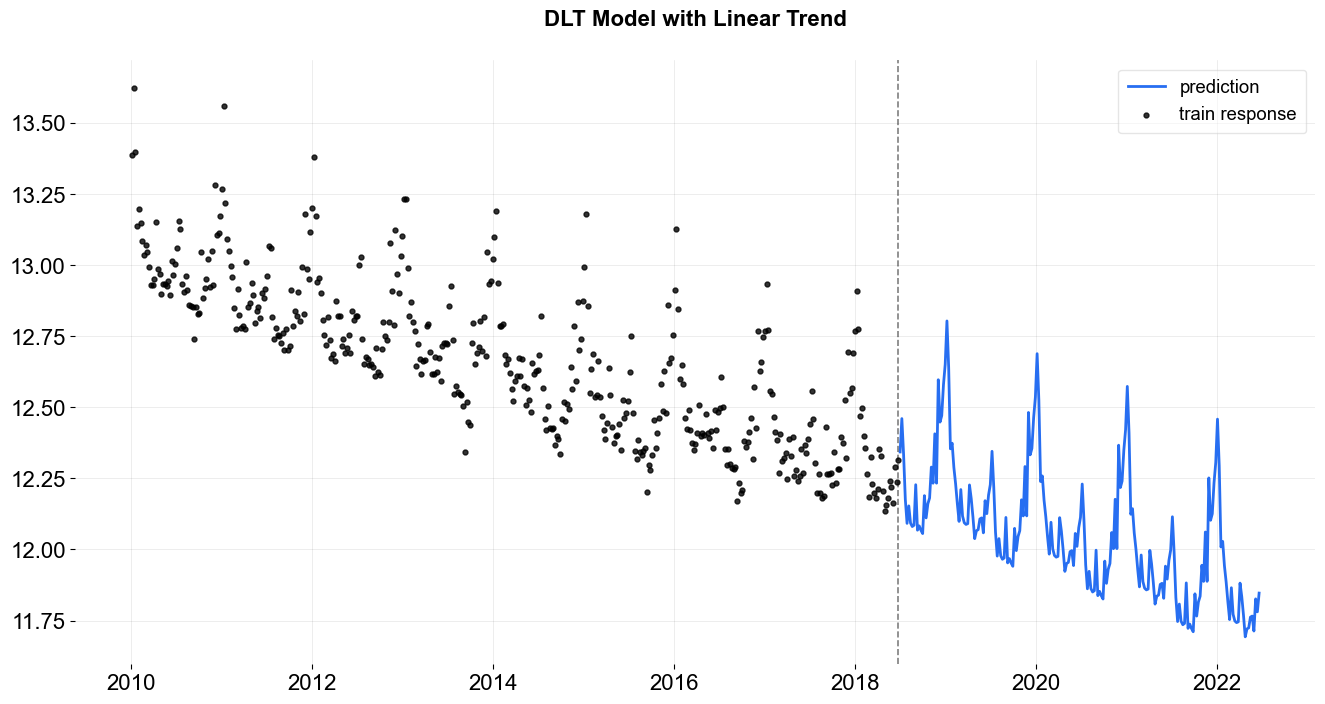

In [26]:
_ = plot_predicted_data(training_actual_df=df,
                        predicted_df=predicted_df, 
                        date_col=DATE_COL,
                        actual_col=RESPONSE_COL,
                        title='DLT Model with Linear Trend')

### Log-Linear Trend

For users who want to maintain linear trend assumption in the multiplicative model, they can switch to `loglinear` global trend.  

In [27]:
dlt_log = DLT(response_col=RESPONSE_COL,
              date_col=DATE_COL,
              estimator='stan-map',
              seasonality=52,
              seed=8888,
              global_trend_option='loglinear')

In [28]:
dlt_log.fit(df=df)

Initial log joint probability = 509.813


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      19       871.407      0.125591        51.165           1           1       20   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      39       885.962      0.231604       15.5396           1           1       41   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      59       890.979      0.106306       33.0745     0.09932           1       65   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      79       893.261     0.0435656       4.41823           1           1       90   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       893.954       0.73179       7.24515           1           1      113   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     119     

In [29]:
predicted_df_dlt_log = dlt_log.predict(df=future_df, decompose=True)

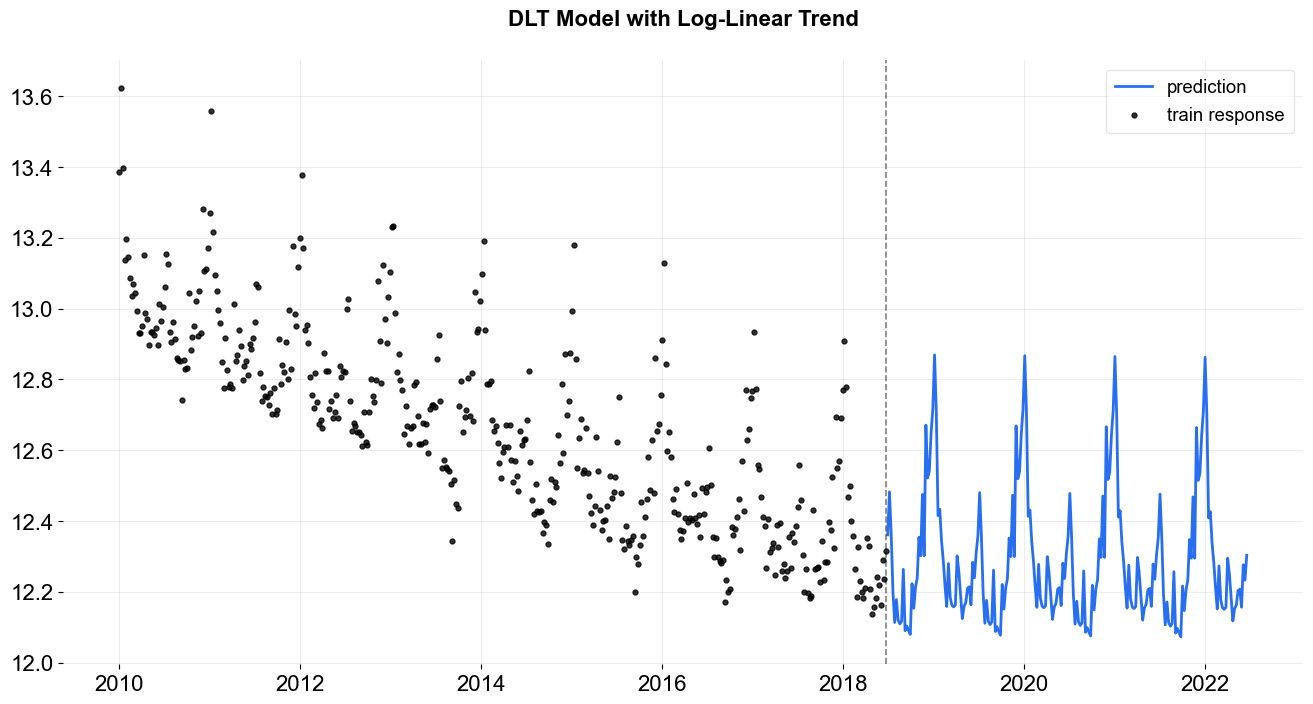

In [30]:
_ = plot_predicted_data(training_actual_df=df,
                        predicted_df=predicted_df_dlt_log, 
                        date_col=DATE_COL,
                        actual_col=RESPONSE_COL,
                        title='DLT Model with Log-Linear Trend')

### Logistic Trend

In case of modeling logistic growth/decay, user can switch to `logistic` in the `global_trend_option`. 

In [31]:
dlt_logit = DLT(response_col=RESPONSE_COL,
                date_col=DATE_COL,
                estimator='stan-map',
                seasonality=52,
                seed=8888,
                global_trend_option='logistic')

In [32]:
dlt_logit.fit(df=df)

Initial log joint probability = 505.306
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      19       873.349       0.32558       28.6737           1           1       23   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      39       892.187      0.109797       16.7602           1           1       43   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      59       900.484      0.115782       15.0319           1           1       65   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      79       901.844     0.0280431       5.01573      0.4352           1       87   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       901.936      0.191349       1.19015           1           1      111   
    Iter      log prob        ||dx||      ||grad||       alpha   

  901.988    0.00217537      0.132631           1           1      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     139        901.99    0.00889812       0.23335           1           1      158   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     159       901.994        0.1947      0.603572           1           1      182   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     179       901.996     0.0114962      0.246274           1           1      206   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        902.02     0.0103449      0.502607      0.2435      0.9888      230   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     219        902.02    0.00383923      0.122783      0.9364      0.9364      253   
    Iter      log prob        |

In [33]:
predicted_df_dlt_logit = dlt_logit.predict(df=future_df, decompose=True)

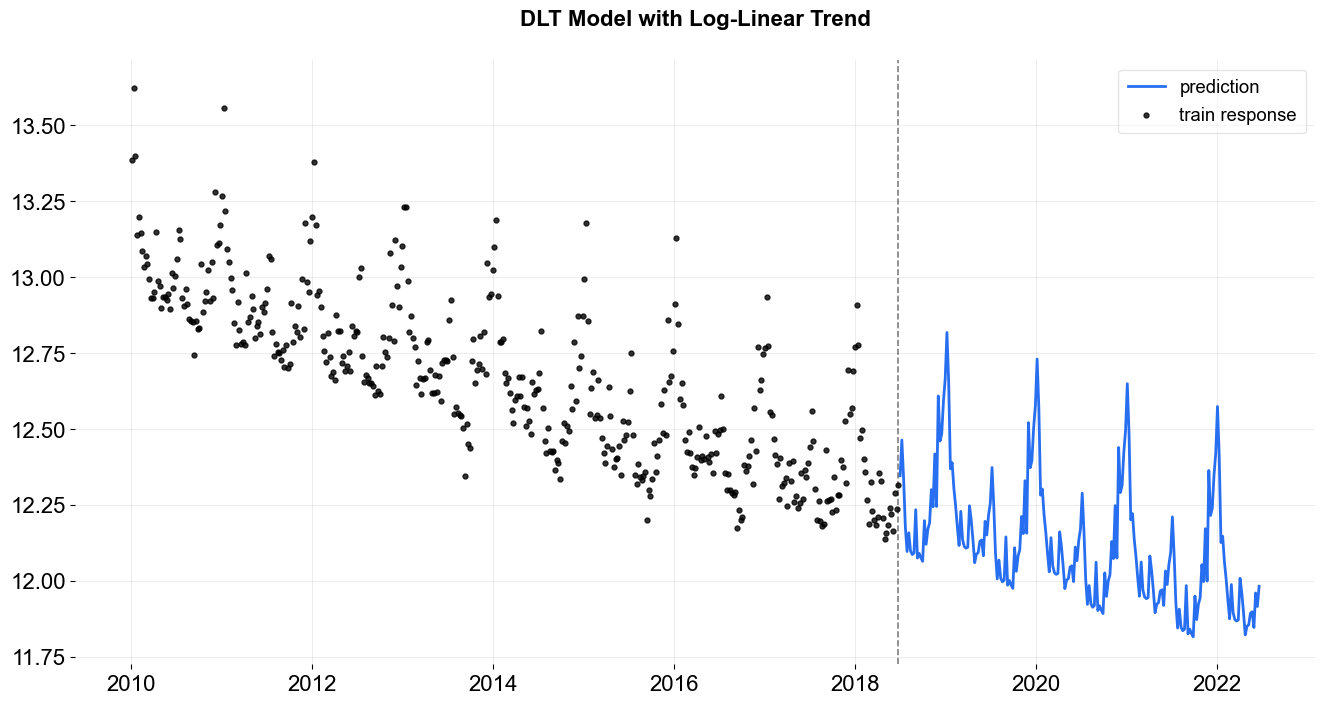

In [34]:
_ = plot_predicted_data(training_actual_df=df,
                        predicted_df=predicted_df_dlt_logit, 
                        date_col=DATE_COL,
                        actual_col=RESPONSE_COL,
                        title='DLT Model with Log-Linear Trend')

### Flat Trend

In [35]:
dlt_logit = DLT(response_col=RESPONSE_COL,
                date_col=DATE_COL,
                estimator='stan-map',
                seasonality=52,
                seed=8888,
                global_trend_option='flat')

In [36]:
dlt_logit.fit(df=df)

Initial log joint probability = 507.596


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      19       869.811      0.158589       45.0645           1           1       20   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      39       883.216      0.637885        25.678           1           1       41   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      59       888.689      0.598889       22.9592           1           1       62   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      79       890.553     0.0204702       0.92227           1           1       84   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      87       890.554   0.000473207     0.0927384      0.4873           1       94   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance

In [37]:
predicted_df_dlt_logit = dlt_logit.predict(df=future_df, decompose=True)

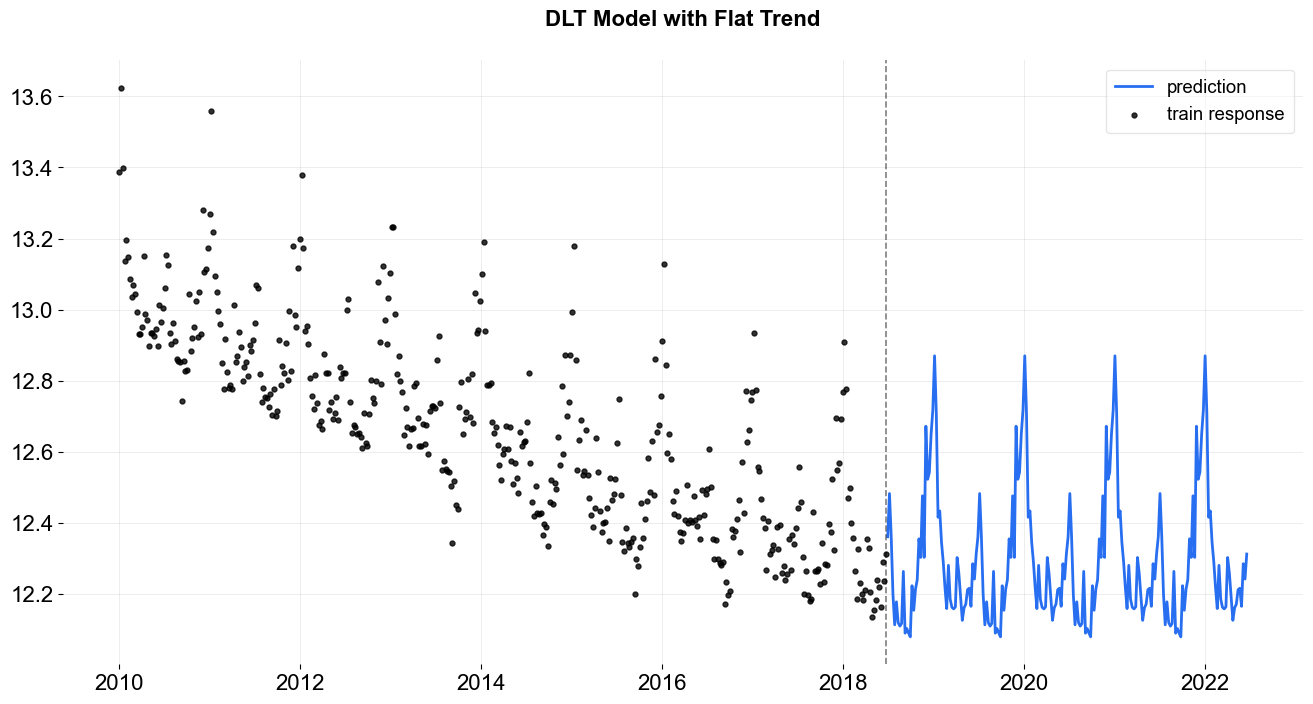

In [38]:
_ = plot_predicted_data(training_actual_df=df,
                        predicted_df=predicted_df_dlt_logit, 
                        date_col=DATE_COL,
                        actual_col=RESPONSE_COL,
                        title='DLT Model with Flat Trend')

More details for each method are available in the docstrings and also here: https://orbit-ml.readthedocs.io/en/latest/orbit.models.html#module-orbit.models.dlt